# The likelihood of the successive note 

Often enough, the theory behind {term}`Large Language Models (LLM) <LLM>` is simplified by creating a continuation of an existing text, following the credo of *what would be the next likely word based on the given input*.
Although in principle this is not false, it does not capture why LLMs can often provide rather convincing results.

The concept of the likelihood of the next word or chapter to follow is though an essential question in stochastic and has been first investigated by Andrey Markov.
In 1906, he used the $20,000$ letters of *Eugene Onegin* by *Alexander Pushkin* to analyze the distribution and patterns of vowels and consonants, and developed a model which nowadays is called *Markov chain* which still finds applications in such algorithms as Google's [PageRank](https://en.wikipedia.org/wiki/PageRank) algorithm.

Therefore we can come up with the first basic generative analysis of our dataset: What is the most likely key to be struck for a given key, which we can then just continue indefinitely.

## Markov chain

In order to create a common understanding of the capabilities and construction of Markov chains it is fruitful to inspect it from a formalistic perspective.

Let $X_0, X_1, X_2, \dots$ be a series of {term}`random variables <Random variable>`.
These variables are called a *markov chain* iff

$$
\mathbb{P}(X_{n+1} = x ~ | ~ X_1 = x_1, X_2 = x_2 \dots X_n = x_n) = \mathbb{P}(X_{n+1} = x | X_n = x_n)
$$

The motivation behind the motivation that within a successive series of random events, the outcome of the next event only depends on the current event and not to any other prior events, therefore the memory of our series is limited to a depth of $1$, and therefore this definition defines a *first order* markov chain.

## Implementing

Markov chains have the benefit of being easy to model and program, therefore it is not necessary to rely on additional libraries (although the are harder problems associated with markov chains like stationary distribution which will not be covered here).

As markov chains can be used to model existing data, it is necessary to first prepare the necessary data.

### Data processing

One of the most obvious things to model is the succession of played notes on the keyboard, therefore it is necessary to extract this data from the *Maestro* data.

In [ ]:
from ki_ueben.datasets import Maestro3
from ki_ueben.midi import PianoRoll

In [ ]:
dataset = Maestro3()
midi_files = dataset.get_midi_files()
print(f"Found {len(midi_files)} midi_files")

Found 1276 midi_files


The easiest way to obtain successive notes from a MIDI file is to take it as a stream of events.

In [ ]:
piano_roll = PianoRoll(midi_files[0])
events = piano_roll.events()
events

,note,velocity,time
0,-1,0,0.000000
1,77,56,0.994792
2,49,32,0.998698
3,77,0,1.087240
4,73,58,1.108073
...,...,...,...
5000,68,0,211.057292
5001,37,0,211.058594
5002,-1,65,211.066406
5003,-1,47,211.088542


In MIDI, each key hit is indicated by a `note_on` and a `note_off` event, where the latter is represented by an event with velocity $0$ in the series of events.

:::note
The note $-1$ indicates the sustain pedal and will be filtered out.
:::

To skip the events which release a key it is possible to simply filter them out, also the events concerning the sustain pedal.

In [ ]:
notes = events[(events["note"] != -1) & (events["velocity"] > 0)].note
notes

1       77
2       49
4       73
6       68
8       73
        ..
4949    37
4950    61
4951    65
4952    68
4953    73
Name: note, Length: 2235, dtype: int64

In order to generate new samples based on a markov chain principle one can rely on the construction of a state transition matrix, which notes the probability of stepping from state $i \in \Omega$ to $j \in \Omega$, so

$$
p_{i,j} = \mathbb{P}(X_{n+1} = j | X_n = i) | i,j \in \Omega
$$

which forms a matrix of size $|\Omega|^2$.

Based on the given series of events it is possible to construct this transition matrix by counting the occurences of each "transition event".

In [ ]:
import numpy as np

transition_matrix = np.zeros((127, 127), dtype=np.int32)

for cur_note, next_note in zip(notes[:-1], notes[1:]):
    transition_matrix[cur_note, next_note] += 1

# take a look at the transitions from note 77 away
transition_matrix[77]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  3,  3,
        1,  0,  8,  2,  1, 11,  0,  4,  1,  3, 11,  0,  6,  0,  0,  0,  0,
        1,  0,  1,  0,  2,  8,  0, 13,  2,  0, 13,  1,  1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In its current state, the transition matrix does not model a distribution because the probabilities do not sum up to $1$.
This can be done by scaling every row of the transition matrix by the sum of it.

In [ ]:
scaled = transition_matrix[77] / (transition_matrix[77].sum())
scaled

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01030928, 0.        , 0.        , 0.03092784,
       0.03092784, 0.01030928, 0.        , 0.08247423, 0.02061856,
       0.01030928, 0.11340206, 0.        , 0.04123711, 0.01030928,
       0.03092784, 0.11340206, 0.        , 0.06185567, 0.        ,
       0.        , 0.        , 0.        , 0.01030928, 0.        ,
       0.01030928, 0.        , 0.02061856, 0.08247423, 0.     

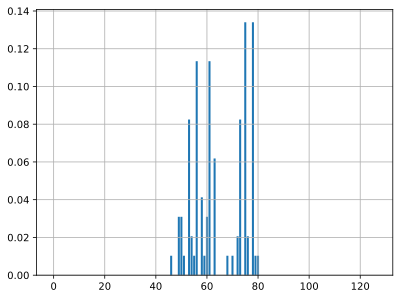

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

plt.bar(x=np.arange(127), height=scaled)
# @todo highlight key 77
plt.grid();

In [ ]:
import numpy as np


class MarkovPiano:
    def __init__(self, transition_matrix: np.ndarray, init_state: int) -> None:
        self.transition_matrix = transition_matrix
        self.state = init_state

    def next(self) -> int:
        self.state = np.random.choice(
            len(self.transition_matrix), p=self.transition_matrix[self.state]
        )
        return self.state

The concept of carfeul crafting algorithms to analyze music has been a long part of music informatics, but with the advent of powerful neural networks.

Yet, this still allows for fruitful investigations, as the algorithms can be tweaked and influenced, aligned and trained much easier than a neural network, and do not consume such vast amounts of resources.

Some other approaches follow the use of generative grammar, which can be found in ...?

In [ ]:
import mido
import pandas as pd

In [ ]:
midi = mido.MidiFile("/home/dennis/Downloads/kolessova04.mid")

In [ ]:
for msg in midi:
    print(msg)
    break

MetaMessage('track_name', name='Sonata No. 2    TatianaKolessova', time=0)


In [ ]:
for msg in midi:
    if msg.type == "set_tempo":
        print(msg.tempo)

512820


In [ ]:
mido.tempo2bpm(512820)

117.000117000117

In [ ]:
m = None

for msg in midi:
    if msg.type == "note_on":
        m = msg

In [ ]:
m.time

0

In [ ]:
events = []
time = 0.0
for msg in midi:
    time += msg.time
    if any([x == msg.type for x in ["note_on", "note_off"]]):
        events.append(
            {
                "note": msg.note,
                "velocity": msg.velocity if msg.type == "note_on" else 0,
                "time": time,
            }
        )
    elif msg.is_cc(64):
        events.append(
            {
                "note": -1,
                "velocity": msg.value,
                "time": time,
            }
        )
events = pd.DataFrame(events)
events["time"] = events["time"].cumsum()

In [ ]:
x = events.pivot_table(
    values="velocity", index="time", columns="note", aggfunc="max"
).fillna(0.0)

note,21,22,23,24,25,26,27,28,29,30,...,94,95,96,97,98,99,100,101,103,105
time_note,,,,,,,,,,,,,,,,,,,,,
0.4935892499999999-65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.5747857499999999-63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6185891249999999-65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6303412499999999-61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.6816232499999999-58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99.81186599999963-73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.84925912499962-80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.89626762499962-75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
x = x.ffill().fillna(0.0)

In [ ]:
import matplotlib.pyplot as plt

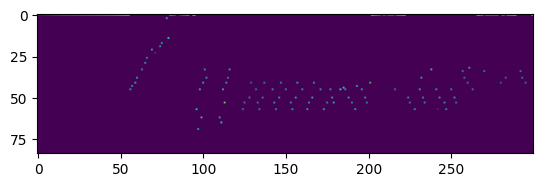

In [ ]:
plt.imshow(x.values.T[:, 0:300])

In [ ]:
events = pd.DataFrame(
    {
        "time": [1, 2, 1, 3, 3, 4],
        "note": ["A", "A", "B", "C", "B", "A"],
        "velocity": [10, 20, 30, 40, 50, 60],
    }
)

# Create a new index by combining 'time' and 'note'
events["time_note"] = events["time"].astype(str) + "-" + events["note"]

# Pivot the table
pivot_table = events.pivot_table(
    values="velocity", index="time_note", columns="note", aggfunc="first"
)

# Drop the temporary 'time_note' column
pivot_table.drop(columns=["time_note"], inplace=True)

## Maestro dataset

In [ ]:
from ki_ueben.datasets import Maestro3

In [ ]:
maestro_dataset = Maestro3()

In [ ]:
midi_files = maestro_dataset.get_midi_files("2013/*.midi")

Building a simple markov chain by checking each transition.

In [ ]:
from ki_ueben.midi import PianoRoll

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
from joblib import Parallel, delayed


def calculate_transition_matrix(midi_file: str) -> np.ndarray:
    transition_matrix = np.zeros((127, 127), dtype=np.int32)

    events = PianoRoll(midi_file).events()
    played_notes = list(events[(events["velocity"] > 0) & (events["note"] != -1)].note)
    for current_note, next_node in zip(played_notes[:-1], played_notes[1:]):
        transition_matrix[current_note, next_node] += 1
    return transition_matrix

In [ ]:
foo = calculate_transition_matrix(midi_files[10])
bar = calculate_transition_matrix(midi_files[100])

In [ ]:
midi_files[100].name

'ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--4.midi'

In [ ]:
midi_files = maestro_dataset.get_midi_files("")

In [ ]:
len(list(maestro_dataset.dataset_dir.glob("2013/*.midi")))

127

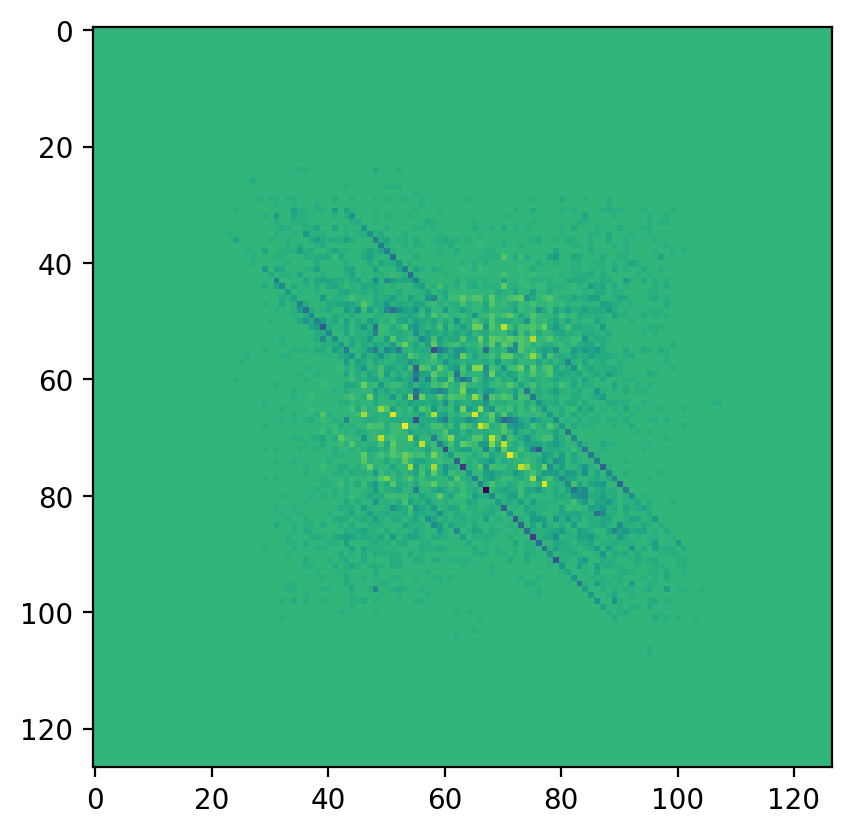

In [ ]:
plt.imshow(foo - bar, interpolation=None)

In [ ]:
midi_files[0] == midi_files[1]

False

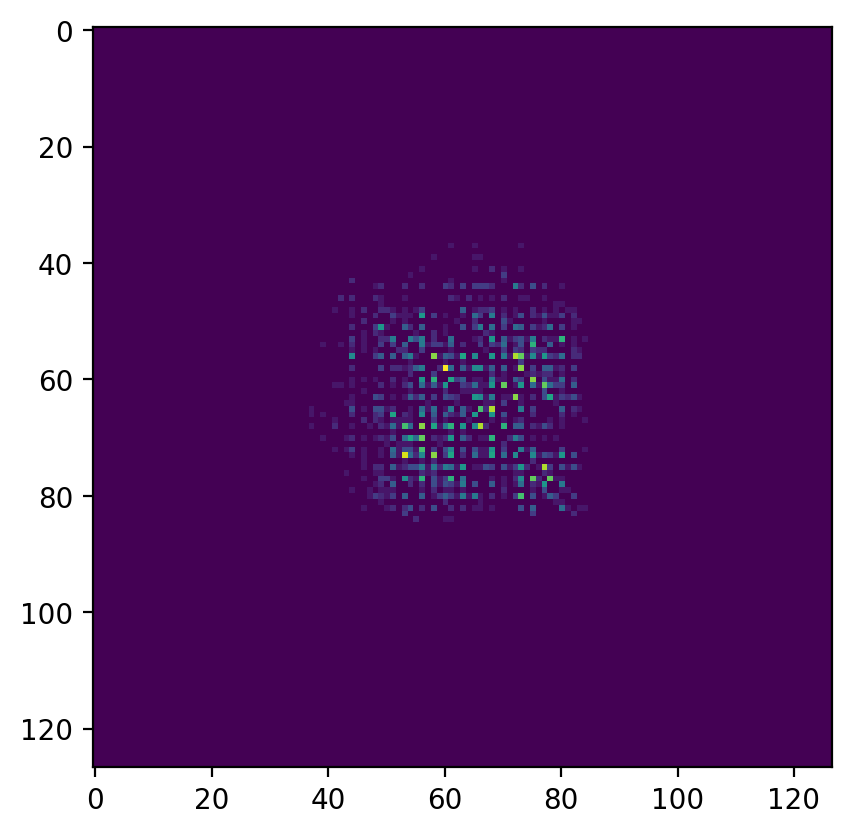

In [ ]:
plt.imshow(calculate_transition_matrix(midi_files[400]), interpolation=None)

In [ ]:
transitions = Parallel(n_jobs=-2)(
    delayed(calculate_transition_matrix)(x)
    for x in maestro_dataset.get_midi_files("2013/*.midi")
)

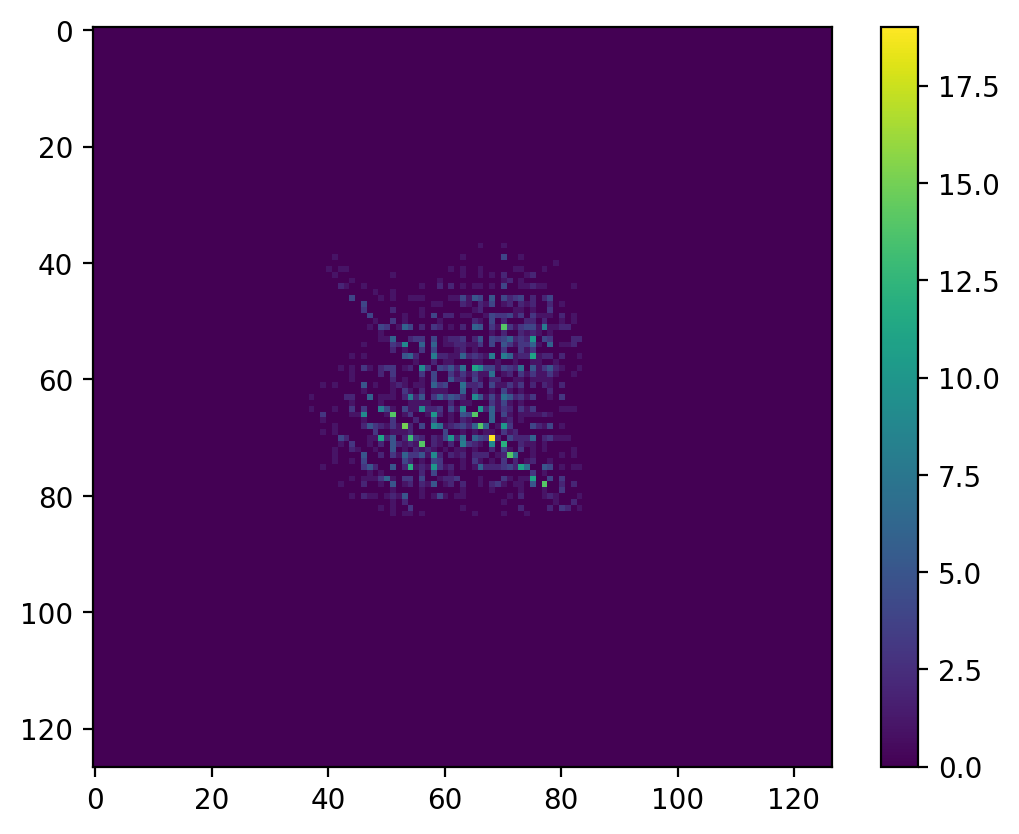

In [ ]:
plt.imshow(transitions[10], interpolation=None)
plt.colorbar()
plt.show();

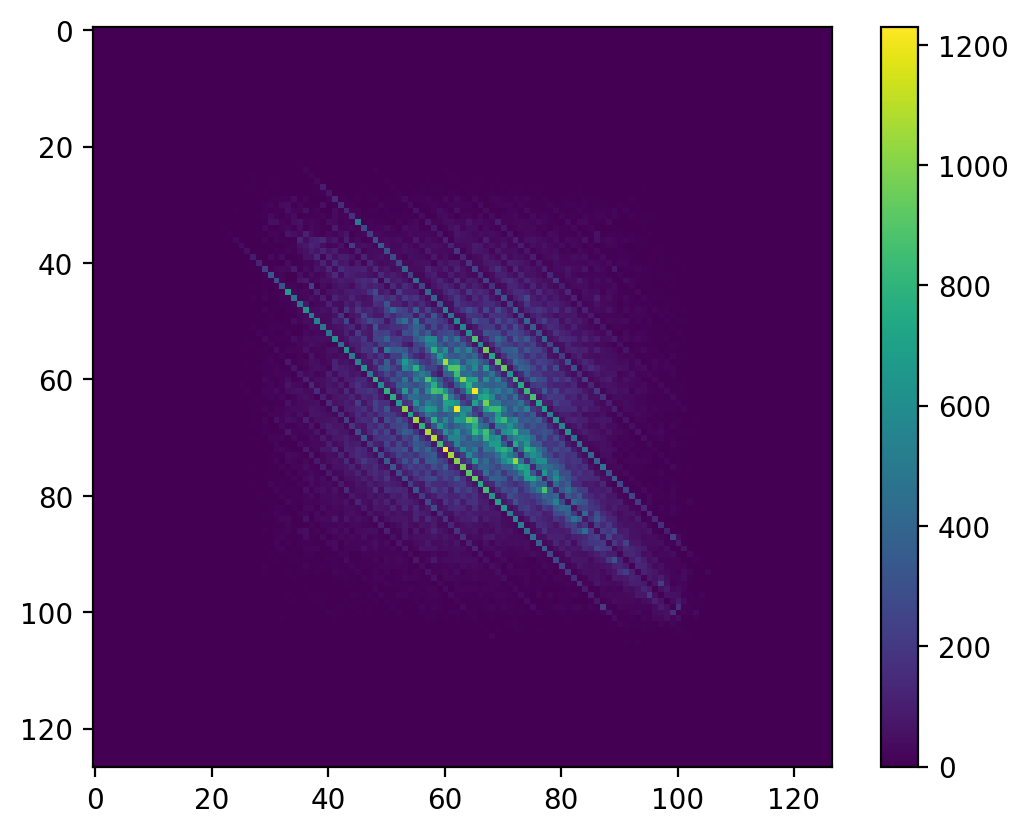

In [ ]:
summed_transition_matrix = np.sum(transitions, axis=(0), dtype=np.int32)
plt.imshow(summed_transition_matrix, interpolation=None)
plt.colorbar()
plt.show();

In [ ]:
summed_transition_matrix[60]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    3,    0,    0,    1,    4,   28,   10,    5,   23,
         39,   11,   18,  115,   26,   47,   51,   72,  105,   37,   94,
         93,  133,  135,   59,  789,   90,  154,  293,  255,  480,  235,
        555,  413,  878,  539,  317,  166,  223,  589, 1028,  683,  713,
        319,  624,  365,  543,  270,  157,  846,   89,  206,  394,  279,
        277,  137,  234,  153,  206,  101,   57,  239,   26,   50,   86,
         93,   47,   25,   57,   29,   25,   14,   10,   33,    8,    7,
          9,    2,    6,    1,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
np.random.choice(
    range(summed_transition_matrix.shape[0]), p=summed_transition_matrix[60]
)

ValueError: probabilities do not sum to 1

In [ ]:
summed_transition_matrix.sum(axis=1)

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     9,    17,    25,    90,   107,   153,
         298,   315,   798,   945,  1085,  1171,  2055,  1685,  2016,
        2919,  2967,  2866,  3074,  3388,  4670,  3868,  5277,  4603,
        6290,  6321,  5922,  8726,  6956,  9580,  8140,  9345, 12212,
        9419, 13376, 10368, 13988, 15045, 11886, 15533, 12926, 16722,
       14068, 14968, 16937, 11945, 16390, 13330, 15765, 14319, 13026,
       15285, 12718, 14313, 12529, 11412, 11882,  8805, 10453,  8208,
        8471,  7283,  6376,  6622,  4864,  5439,  4693,  4158,  3854,
        2665,  2974,  2292,  2295,  1909,  1688,  1309,  1467,  1038,
        1181,   908,   487,   214,   124,    54,    48,     5,     5,
           2,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [ ]:
np.arange(2)

array([0, 1])

In [ ]:
class Markov:
    def __init__(self, transition_matrix: np.ndarray) -> None:
        self.m = transition_matrix

    def next(self, state: int) -> int:
        return np.random.choice(
            np.arange(self.m.shape[0]), p=self.m[state] / (self.m[state].sum())
        )

In [ ]:
markov = Markov(transition_matrix=summed_transition_matrix)

In [ ]:
markov.next(60)

57

In [ ]:
import asyncio
from functools import partial
from typing import List

import mido

In [ ]:
class MidiPlayer:
    def __init__(self, device_name: str = "MIDILINK-mini") -> None:
        self.midi_out = mido.open_output(device_name)

    @staticmethod
    def print_devices() -> List[str]:
        return mido.get_input_names()

    def playback(self, midi_data):
        pass

    def play_message(self, message: mido.Message):
        self.midi_out.send(message)

    def play_note(self, note: int, velocity: int = 40, type="note_on", channel=0):
        self.play_message(
            mido.Message(
                type,
                note=note,
                velocity=velocity,
                channel=channel,
            )
        )

    async def async_play_note(
        self, note: int, velocity: int = 40, sustain=0.1, channel=0
    ):
        play = partial(self.play_note, note=note, velocity=velocity, channel=channel)
        play()
        await asyncio.sleep(sustain)
        play(type="note_off")

    async def async_playback(self):
        pass

    def stop_all(self):
        self.play_message(
            mido.Message(
                "control_change",
                control=120,
            )
        )

In [ ]:
m = MidiPlayer()

In [ ]:
import time

# start note
n = 60

for _ in range(30):
    n = markov.next(n)
    await m.async_play_note(n, sustain=0.2)

m.stop_all()

This plays back the most likely note derived from out dataset, but we will soon realize that this does not capture

* rhythm
* phrasing
* velocity
* polyphony

Also, because the context provided only consists of the prior note, the system fails to comprehend concepts like a *key*, which can only be established through a larger context and not just through two successive notes.

In order to provide a larger context it is possible to increase the number of steps the markov chain takes into account, which is labeled as *n-th order markov chain*.
Yet this increases our transition matrix from a $m \times m$ matrix to a $n \times m \times m$ matrix, where $m$ is the number of possible states.

Our *state space* increases further if we take polyphony into account, and at this point it is clear that while markov chain are a very interesting mathematical objects, they do not perform well on tasks such as generalization as if the state space is too restrictive.
This is, because markov chain rely on independence of its state variables, yet music happens within a context and the articulation of a single note also correlates with the *function* of said note.

Nonetheless, we must not use markov chains to create a perfect replications of something already existing, but can instead use this as a generative method on its own.

To make the system more expressive, it is possible to create a markov chain for multiple parameters, which then can be used in a serial manner.

In [ ]:
midi_file = midi_files[0]
piano_roll = PianoRoll(midi_file)
df = piano_roll.events()

In [ ]:
import pandas as pd

In [ ]:
pd.cut(df["time"].diff()[1:], np.arange(20) / 100)

1                NaN
2        (0.0, 0.01]
3       (0.08, 0.09]
4       (0.02, 0.03]
5       (0.06, 0.07]
            ...     
5000     (0.0, 0.01]
5001     (0.0, 0.01]
5002     (0.0, 0.01]
5003    (0.02, 0.03]
5004    (0.01, 0.02]
Name: time, Length: 5004, dtype: category
Categories (19, interval[float64, right]): [(0.0, 0.01] < (0.01, 0.02] < (0.02, 0.03] < (0.03, 0.04] ... (0.15, 0.16] < (0.16, 0.17] < (0.17, 0.18] < (0.18, 0.19]]

In [ ]:
(df[df["note"] == 77].diff()[1::2]["time"] * 16).round() / 16

3       0.0625
14      0.0625
85      0.1250
91      0.1250
100     0.1250
         ...  
4265    0.1250
4282    0.9375
4291    0.2500
4385    0.8125
4701    0.0625
Name: time, Length: 97, dtype: float64

In [ ]:
from joblib import Parallel, delayed


def additional_matrix(midi_file: str) -> np.ndarray:
    events = PianoRoll(midi_file).events()

    # extract notes
    note_transition = np.zeros((127, 127), dtype=np.int32)
    played_notes = list(events[(events["velocity"] > 0) & (events["note"] != -1)].note)
    for current_note, next_node in zip(played_notes[:-1], played_notes[1:]):
        note_transition[current_note, next_node] += 1

    velocity_transition = np.zeros((127, 127), dtype=np.int32)
    played_velocities = list(
        events[(events["velocity"] > 0) & (events["note"] != -1)].velocity
    )
    for current_note, next_node in zip(played_velocities[:-1], played_velocities[1:]):
        note_transition[current_note, next_node] += 1

    duration_transition = np.zeros((127, 127), dtype=np.int32)
    played_notes = list(events[(events["velocity"] > 0) & (events["note"] != -1)].note)
    for current_note, next_node in zip(played_notes[:-1], played_notes[1:]):
        duration_transition[current_note, next_node] += 1

    return (note_transition,)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
m.play_note(50)

In [ ]:
m.stop_all()

In [ ]:
transition_matrix = np.zeros((127, 127))

for midi_file in tqdm(maestro_dataset.get_midi_files("2013/*.midi")):
    piano_roll = PianoRoll(midi_file).piano_roll()
    played_notes = list(events[(events["velocity"] > 0) & (events["note"] != -1)].note)
    for current_note, next_node in zip(played_notes[:-1], played_notes[1:]):
        transition_matrix[current_note, next_node] += 1

 22%|██▏       | 280/1276 [06:05<21:40,  1.31s/it]


KeyboardInterrupt: 

In [ ]:
for current_note, next_node in zip(played_notes[:-1], played_notes[1:]):
    transition_matrix[current_note, next_node] += 1

In [ ]:
transition_matrix[0, 0] += 1

In [ ]:
transition_matrix.shape

(127, 127)

In [ ]:
transition_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

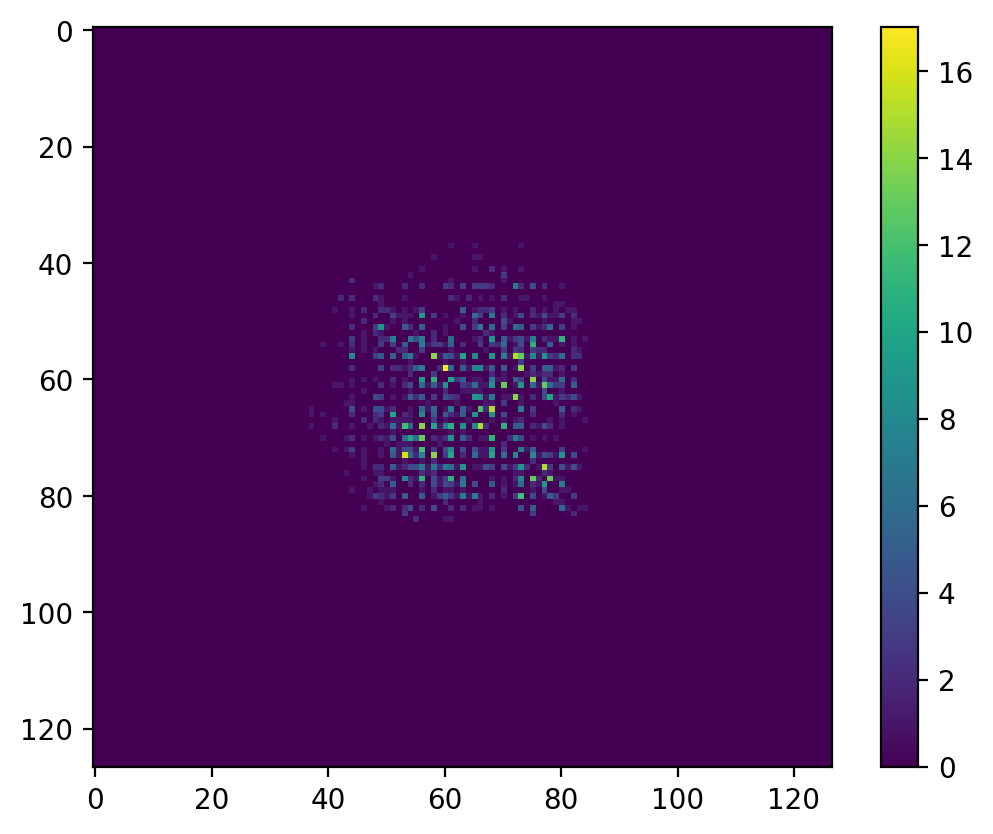

In [ ]:
plt.imshow(transition_matrix, interpolation=None)
plt.colorbar()
plt.show()